In [1]:
from fastai2.vision.all import *

from pathlib import Path
ROOT = Path('..').resolve()

sys.path.append(f'{ROOT}/src')

In [2]:
import tensorflow as tf
from tfrecord.tfrecord import *

import kornia
from mish_cuda import MishCuda
from deconvolution.models.deconv import *
from xresnet_deconv import *

In [3]:
def replace_model_layer(model, layer_type_old, new_layer):
    conversion_count = 0
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = replace_model_layer(module, layer_type_old, new_layer)

        if type(module) == layer_type_old:
            layer_old = module
            model._modules[name] = new_layer

    return model

def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps
    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)       
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

# Get data

In [4]:
train_fnames = get_files(ROOT/'data/flowers/train', extensions='.tfrec')
test_fnames = get_files(ROOT/'data/flowers/val', extensions='.tfrec')

In [5]:
def unpack_sample(feats):
    return {
        'class' : unpack_int64_list(feats['class']),
        'image' : unpack_bytes_list(feats['image'])
    }

data = []
for name in train_fnames+test_fnames:
    r = Reader(str(name), unpack_sample)
    for sample in r:
        data.append([sample['image'][0], sample['class'][0]])

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [6]:
get_x = lambda o: PILImage.create(io.BytesIO(o[0]))
get_y = lambda o: o[1]

def get_items(noop): return data

In [7]:
splitter = IndexSplitter(range(12753, len(data)))

In [8]:
item_tfms = [RandomResizedCrop(224, min_scale=0.7)]
batch_tfms = [*aug_transforms()]

In [9]:
block = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_items,
    get_x=get_x,
    get_y=get_y,
    splitter=splitter,
    item_tfms=item_tfms,
    batch_tfms=batch_tfms
)

dls = block.dataloaders('', bs=64)

# Train model

SuggestedLRs(lr_min=0.0013182567432522773, lr_steep=0.0010000000474974513)

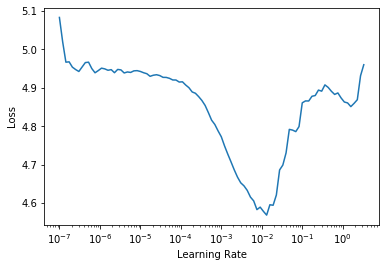

In [10]:
model = xresnet50_deconv(n_out=dls.c)
learn = Learner(dls, model, opt_func=ranger, metrics=accuracy)

learn.lr_find()

## lr=6e-3, wd=1e-2

In [19]:
model = xresnet50_deconv(n_out=dls.c)
learn = Learner(dls, model, opt_func=ranger, metrics=accuracy)
learn.fit_flat_cos(5, 6e-3, wd=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.871807,2.599745,0.349407,01:29
1,2.295386,2.405307,0.393319,01:29
2,1.950252,2.237605,0.439386,01:29
3,1.670249,1.781574,0.537446,01:29
4,1.193540,1.158748,0.693427,01:29


## + self-attention

In [21]:
model = xresnet50_deconv(n_out=dls.c, sa=True)
learn = Learner(dls, model, opt_func=ranger, metrics=accuracy)
learn.fit_flat_cos(5, 6e-3, wd=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.770606,2.490908,0.374192,01:39
1,2.183174,2.278737,0.399246,01:40
2,1.791324,2.298132,0.448006,01:39
3,1.522760,1.988969,0.468211,01:39
4,1.054363,1.015510,0.728718,01:39


## + Mish

In [24]:
model = xresnet50_deconv(n_out=dls.c, sa=True, act_cls=MishCuda)
learn = Learner(dls, model, opt_func=ranger, metrics=accuracy)
learn.fit_flat_cos(5, 6e-3, wd=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.653203,2.316998,0.405711,01:42
1,1.974992,1.912254,0.491379,01:43
2,1.588604,1.755251,0.539871,01:42
3,1.343393,1.389859,0.635776,01:42
4,0.878363,0.881233,0.766972,01:42


## + LabelSmoothingCrossEntropy

In [9]:
model = xresnet50_deconv(n_out=dls.c, sa=True, act_cls=MishCuda)
learn = Learner(dls, model, opt_func=ranger, metrics=accuracy, loss_func=LabelSmoothingCrossEntropy())
learn.fit_flat_cos(5, 6e-3, wd=1e-2)

@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.019185,2.696029,0.429957,01:45
1,2.468560,2.401762,0.511315,01:42
2,2.235270,2.378911,0.526401,01:42
3,2.023322,2.066873,0.632543,01:42
4,1.671154,1.666946,0.770205,01:42


## + maxBlurPool

In [26]:
model = xresnet50_deconv(n_out=dls.c, sa=True, act_cls=MishCuda)
model = replace_model_layer(model, nn.MaxPool2d, kornia.contrib.MaxBlurPool2d(3, True))
learn = Learner(dls, model, opt_func=ranger, metrics=accuracy, loss_func=LabelSmoothingCrossEntropy())
learn.fit_flat_cos(5, 6e-3, wd=1e-2)

@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,2.988489,2.832647,0.382004,01:56
1,2.472663,2.447105,0.509160,01:57
2,2.194036,2.245527,0.572468,01:57
3,1.981459,2.055447,0.641972,01:57
4,1.652544,1.645228,0.769397,01:57


## + increase wd

In [10]:
model = xresnet50_deconv(n_out=dls.c, sa=True, act_cls=MishCuda)
model = replace_model_layer(model, nn.MaxPool2d, kornia.contrib.MaxBlurPool2d(3, True))
learn = Learner(dls, model, opt_func=ranger, metrics=accuracy, loss_func=LabelSmoothingCrossEntropy())
learn.fit_flat_cos(5, 6e-3, wd=5e-2)

@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.000506,2.724685,0.428610,02:01
1,2.456052,2.445323,0.500539,01:56
2,2.193381,2.269508,0.568965,01:56
3,2.006953,2.153033,0.605603,01:56
4,1.652074,1.642461,0.774246,01:56


## + earlier annealing

In [12]:
model = xresnet50_deconv(n_out=dls.c, sa=True, act_cls=MishCuda)
model = replace_model_layer(model, nn.MaxPool2d, kornia.contrib.MaxBlurPool2d(3, True))
learn = Learner(dls, model, opt_func=ranger, metrics=accuracy, loss_func=LabelSmoothingCrossEntropy())
learn.fit_flat_cos(5, 6e-3, pct_start=0.5, wd=5e-2)

@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.062837,2.786276,0.389278,01:56
1,2.535457,2.400937,0.515086,01:57
2,2.194929,2.195554,0.591595,01:57
3,1.888434,1.859598,0.699623,01:57
4,1.619322,1.659664,0.765086,01:57


## + early annealing -maxblurpool

In [13]:
model = xresnet50_deconv(n_out=dls.c, sa=True, act_cls=MishCuda)
learn = Learner(dls, model, opt_func=ranger, metrics=accuracy, loss_func=LabelSmoothingCrossEntropy())
learn.fit_flat_cos(5, 6e-3, pct_start=0.5, wd=5e-2)

@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.013574,2.944211,0.378502,01:42
1,2.511835,2.370032,0.524246,01:42
2,2.198093,2.248867,0.570312,01:42
3,1.872661,1.824495,0.715787,01:42
4,1.608403,1.675243,0.765086,01:42


## + early annealing -maxblurpool, original wd

In [14]:
model = xresnet50_deconv(n_out=dls.c, sa=True, act_cls=MishCuda)
learn = Learner(dls, model, opt_func=ranger, metrics=accuracy, loss_func=LabelSmoothingCrossEntropy())
learn.fit_flat_cos(5, 6e-3, pct_start=0.5, wd=1e-2)

@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.055231,2.778242,0.418103,01:42
1,2.526263,2.471820,0.496498,01:42
2,2.210315,2.175170,0.587285,01:42
3,1.873833,1.846916,0.706627,01:42
4,1.607935,1.667732,0.768050,01:42


## + lowered label smoothing, + slightly increased wd

In [18]:
model = xresnet50_deconv(n_out=dls.c, sa=True, act_cls=MishCuda)
learn = Learner(dls, model, opt_func=ranger, metrics=accuracy, loss_func=LabelSmoothingCrossEntropy(eps=0.05))
learn.fit_flat_cos(5, 6e-3, wd=3e-2)

@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,2.833863,2.591652,0.407597,01:42
1,2.190644,2.116256,0.541218,01:42
2,1.906302,2.158124,0.561961,01:42
3,1.705161,1.947041,0.564116,01:42
4,1.290601,1.305641,0.774246,01:42


## Best hyperparams:
  - lr=6e-3
  - wd=3e-2?
  - sa=True
  - act_cls=MishCuda
  - loss_func=LabelSmoothingCrossEntropy() -- perhaps eps=0.05?
  - fit_flat_cos with default annealing

# tweaked xse_resnext9_deconv 
see e.g., `mini_net` from https://github.com/pete88b/data-science/blob/master/fastai-things/train-imagenette-mininet.ipynb


In [18]:
def xse_resnext9_deconv(pretrained=False, **kwargs):
    return XResNet_deconv(
        SEResNeXtBlock, 
        expansion=1, 
        layers=[1,1,1,1], 
        **kwargs
    )

## Test default groups/reduction = 32/16

In [35]:
model = xse_resnext9_deconv(n_out=dls.c, sa=True, act_cls=MishCuda, groups=32, reduction=16)
learn = Learner(dls, model, opt_func=ranger, metrics=accuracy, loss_func=LabelSmoothingCrossEntropy(eps=0.05))
learn.fit_flat_cos(5, 6e-3, wd=3e-2)

@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.006123,2.735064,0.358836,00:42
1,2.510010,2.467961,0.431304,00:41
2,2.102702,2.124415,0.528825,00:41
3,1.833704,1.820477,0.603718,00:41
4,1.461227,1.437112,0.732489,00:41


## try groups/reduction = 64/8 

In [11]:
model = xse_resnext9_deconv(n_out=dls.c, sa=True, act_cls=MishCuda, groups=64, reduction=8)
learn = Learner(dls, model, opt_func=ranger, metrics=accuracy, loss_func=LabelSmoothingCrossEntropy(eps=0.05))
learn.fit_flat_cos(5, 6e-3, wd=3e-2)

@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,2.984356,2.818455,0.332705,00:50
1,2.482142,2.262063,0.486261,00:48
2,2.042725,1.981019,0.562500,00:48
3,1.773626,1.822617,0.615840,00:48
4,1.393142,1.391313,0.752694,00:48


## Increase lr

In [12]:
model = xse_resnext9_deconv(n_out=dls.c, sa=True, act_cls=MishCuda, groups=64, reduction=8)
learn = Learner(dls, model, opt_func=ranger, metrics=accuracy, loss_func=LabelSmoothingCrossEntropy(eps=0.05))
learn.fit_flat_cos(5, 1e-2, wd=3e-2)

@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,2.981895,2.792094,0.332435,00:48
1,2.330408,2.320021,0.500539,00:48
2,1.924669,1.974490,0.571929,00:48
3,1.639007,1.871776,0.618804,00:48
4,1.290601,1.296335,0.783944,00:48


## Re-up labelsmoothing eps

In [13]:
model = xse_resnext9_deconv(n_out=dls.c, sa=True, act_cls=MishCuda, groups=64, reduction=8)
learn = Learner(dls, model, opt_func=ranger, metrics=accuracy, loss_func=LabelSmoothingCrossEntropy(eps=0.1))
learn.fit_flat_cos(5, 1e-2, wd=3e-2)

@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.166513,2.982512,0.335129,00:48
1,2.636948,2.491567,0.484375,00:48
2,2.305517,2.245510,0.567349,00:48
3,2.030368,2.159607,0.591864,00:48
4,1.666713,1.668765,0.766164,00:48


## decrease wd=1e-2

In [14]:
model = xse_resnext9_deconv(n_out=dls.c, sa=True, act_cls=MishCuda, groups=64, reduction=8)
learn = Learner(dls, model, opt_func=ranger, metrics=accuracy, loss_func=LabelSmoothingCrossEntropy(eps=0.05))
learn.fit_flat_cos(5, 1e-2, wd=1e-2)

@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.032901,2.767097,0.342134,00:48
1,2.390874,2.218745,0.502425,00:48
2,1.936306,1.839335,0.609914,00:48
3,1.633554,1.739221,0.639009,00:48
4,1.261247,1.290966,0.779095,00:48


## decrease wd=6e-3

In [19]:
model = xse_resnext9_deconv(n_out=dls.c, sa=True, act_cls=MishCuda, groups=64, reduction=8)
learn = Learner(dls, model, opt_func=ranger, metrics=accuracy, loss_func=LabelSmoothingCrossEntropy(eps=0.05))
learn.fit_flat_cos(5, 1e-2, wd=6e-3)

@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,2.981231,2.734114,0.351562,00:48
1,2.360242,2.279036,0.460129,00:48
2,1.943474,1.898587,0.588093,00:48
3,1.647050,1.702258,0.645205,00:48
4,1.283010,1.318186,0.765086,00:48


## increase lr=3e-2

In [16]:
model = xse_resnext9_deconv(n_out=dls.c, sa=True, act_cls=MishCuda, groups=64, reduction=8)
learn = Learner(dls, model, opt_func=ranger, metrics=accuracy, loss_func=LabelSmoothingCrossEntropy(eps=0.05))
learn.fit_flat_cos(5, 3e-2, wd=1e-2)

@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,2.984137,2.907587,0.320851,00:48
1,2.362874,2.428924,0.455011,00:48
2,2.008736,2.165148,0.506735,00:48
3,1.752329,1.757653,0.625000,00:48
4,1.329964,1.302384,0.770474,00:48


## + maxblurpool

In [20]:
model = xse_resnext9_deconv(n_out=dls.c, sa=True, act_cls=MishCuda, groups=64, reduction=8)
model = replace_model_layer(model, nn.MaxPool2d, kornia.contrib.MaxBlurPool2d(3, True))
learn = Learner(dls, model, opt_func=ranger, metrics=accuracy, loss_func=LabelSmoothingCrossEntropy(eps=0.05))
learn.fit_flat_cos(5, 1e-2, wd=1e-2)

@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,2.979276,2.665816,0.365571,01:03
1,2.324918,2.194679,0.508351,01:02
2,1.921980,1.860909,0.597252,01:03
3,1.623020,1.672169,0.663793,01:03
4,1.273025,1.285029,0.784752,01:03


# Final xse_resnext9 with deconv results: 

## With MBP: 77.76% ± 0.28%

In [26]:
for i in range(5):
    model = xse_resnext9_deconv(n_out=dls.c, sa=True, act_cls=MishCuda, groups=64, reduction=8)
    model = replace_model_layer(model, nn.MaxPool2d, kornia.contrib.MaxBlurPool2d(3, True))
    learn = Learner(dls, model, opt_func=ranger, metrics=accuracy, loss_func=LabelSmoothingCrossEntropy(eps=0.05))
    learn.fit_flat_cos(5, 1e-2, wd=1e-2)

@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,2.973083,2.697643,0.375269,01:03
1,2.362395,2.477004,0.454203,01:03
2,1.968845,2.019870,0.550916,01:02
3,1.664431,1.747101,0.636584,01:03
4,1.298846,1.301005,0.778825,01:03


@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,2.969285,2.700739,0.366918,01:03
1,2.362848,2.189211,0.508351,01:02
2,1.956374,1.916693,0.581088,01:02
3,1.679357,1.755833,0.626616,01:03
4,1.285263,1.286050,0.779903,01:03


@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.023259,2.748037,0.340787,01:03
1,2.353920,2.177930,0.504580,01:03
2,1.936009,1.970255,0.559806,01:02
3,1.619180,1.992797,0.569774,01:03
4,1.271850,1.299084,0.773168,01:03


@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,2.965937,2.725139,0.357220,01:02
1,2.351563,2.265059,0.485453,01:03
2,1.948095,1.922212,0.580550,01:03
3,1.645165,1.685279,0.648168,01:03
4,1.287310,1.304496,0.780711,01:03


@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,2.948236,2.737360,0.363416,01:02
1,2.354695,2.226447,0.497306,01:03
2,1.974456,2.081841,0.531519,01:03
3,1.657774,1.661935,0.682920,01:03
4,1.281342,1.308097,0.775593,01:03


In [30]:
res = np.array([0.778825, 0.779903, 0.773168, 0.780711, 0.775593])
print('{:.2f}% +/- {:.2f}%'.format(100*res.mean(), 100*res.std()))

77.76% +/- 0.28%


## Increased wd: 77.75% ± 0.38%

In [32]:
for i in range(5):
    model = xse_resnext9_deconv(n_out=dls.c, sa=True, act_cls=MishCuda, groups=64, reduction=8)
    model = replace_model_layer(model, nn.MaxPool2d, kornia.contrib.MaxBlurPool2d(3, True))
    learn = Learner(dls, model, opt_func=ranger, metrics=accuracy, loss_func=LabelSmoothingCrossEntropy(eps=0.05))
    learn.fit_flat_cos(5, 1e-2, wd=3e-2)

@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,3.003775,2.735956,0.360722,01:03
1,2.377658,2.233840,0.489494,01:03
2,1.948503,1.908787,0.583244,01:03
3,1.665126,1.717383,0.644397,01:03
4,1.275463,1.286993,0.780981,01:03


@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,2.971442,2.725098,0.368804,01:02
1,2.340967,2.241779,0.495420,01:03
2,1.934186,1.906241,0.586476,01:03
3,1.650488,1.614063,0.683998,01:03
4,1.253767,1.279309,0.782328,01:03


@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,2.955700,2.777670,0.343211,01:03
1,2.399532,2.463540,0.422144,01:03
2,1.989056,1.977161,0.566810,01:03
3,1.711841,1.815055,0.625000,01:03
4,1.339256,1.323635,0.772090,01:03


@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,2.967578,2.733002,0.359375,01:03
1,2.335084,2.246750,0.476293,01:03
2,1.946717,1.987058,0.554688,01:03
3,1.637605,1.757245,0.643050,01:03
4,1.234499,1.279198,0.777209,01:03


@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,time
0,2.963636,2.923130,0.333244,01:03
1,2.336338,2.224515,0.502425,01:03
2,1.987592,1.916274,0.583513,01:03
3,1.678603,1.765207,0.624461,01:03
4,1.291927,1.312187,0.775054,01:03


In [34]:
res = np.array([0.780981, 0.782328, 0.772090, 0.777209, 0.775054])
print('{:.2f}% +/- {:.2f}%'.format(100*res.mean(), 100*res.std()))

77.75% +/- 0.38%
